<a href="https://colab.research.google.com/github/audevuilli/Roofpedia/blob/main/Roofpedia_London.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roofpedia - London

1. Download Greater London Boundary as a geojson file. The link for this can be found here. 
2. Generate map tiles for Greater London area using OpenMapTiles, Tippcanoe or Geojson2mvt
3. Download aerial imagery at 25cm resolution for Greater London area using DigiMap Edina Dataset. 
4. Use Roofpedia library to map green and solar roofs.  

## Step 1 - Greater London Boundary File

- Greater London Area (Geographic Boundaries for London Boroughs, Wards, LSOA, MSOA, OA). Available on London Datastore: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
- Open Street Map Data for Greater London Area. Available on Geofabrik: http://download.geofabrik.de/europe/great-britain/england/greater-london.html

In [ ]:
!pip install geopandas

In [ ]:
!apt install libspatialindex-dev
!pip install rtree

In [48]:
# import the necessary library
import pandas as pd
import geopandas as gpd
import shapely.geometry
from shapely import wkt
import numpy as np 
import os
import ast

import rtree

import seaborn as sns
import matplotlib.pyplot as plt

## import pygsheets

import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 400)

In [ ]:
## Download the zip file from the url 
!wget "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"

In [ ]:
## Unzip the downloaded zip folder containing the data
!unzip /content/statistical-gis-boundaries-london.zip

In [7]:
gla_path = '/content/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp'

In [8]:
# read the file
gdf_london = gpd.read_file(gla_path)
# change the crs and write it in geojson
#gdf_london.to_crs(epsg=4326).to_file(root_path+"london_borough.geojson", driver='GeoJSON')
#gdf_london = gdf_london.to_crs(epsg=4326)
gdf_london.head(1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."


In [9]:
print(gdf_london['geometry'][0])

POLYGON ((516401.6 160201.8, 516407.3 160210.5, 516413.3 160217.4, 516419.9 160224.2, 516427.9 160231.3, 516453.8 160253, 516472.8 160275.3, 516486.6 160296.2, 516493.8 160310.2, 516500.9 160324.2, 516507.3 160343.6, 516507.2 160358.3, 516502.3 160395.3, 516500.3 160421.5, 516491.1 160483.9, 516486.7 160493.9, 516472.7 160521.7, 516470.2 160556.7, 516468.9 160567.2, 516461.7 160590.2, 516459.2 160610.3, 516459 160620.9, 516459.1 160632, 516462.4 160702.2, 516462.5 160741.9, 516467.2 160775.7, 516471.3 160798, 516466.7 160810.1, 516473.7 160853.1, 516474.5 160882.9, 516477.6 160904.4, 516487.3 160940.6, 516487.3 160973.9, 516485.3 161015.6, 516485.7 161060.1, 516494 161156.5, 516502.3 161223.8, 516503.2 161279.8, 516501.4 161318.8, 516501.6 161361.4, 516500.8 161380.4, 516500 161398.8, 516493.3 161438.8, 516491.6 161452.4, 516495.1 161513.2, 516503.3 161546.7, 516518.2 161621.8, 516519.3 161624.8, 516531.1 161655.2, 516540.5 161685.7, 516552.2 161756.6, 516555.8 161800.4, 516557.4 16184

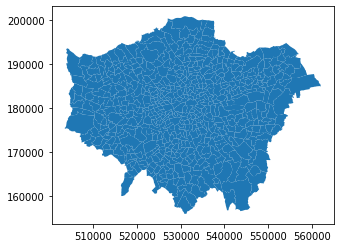

In [10]:
gdf_london.plot()

## Step 2 - Greater London Area - Grid & Vector Tiles

- https://github.com/NYCPlanning/labs-geojson2mvt/tree/master/example
- https://github.com/openmaptiles/openmaptiles
- https://github.com/mapbox/tippecanoe
- https://james-brennan.github.io/posts/fast_gridding_geopandas/ 



#### Step 2.1 GLA Bounds

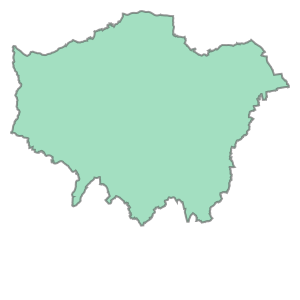

In [11]:
# Get the exterior boundary of GLA - Union of all geometries. 
gla_exterior = gdf_london.unary_union
gla_exterior

In [12]:
# Get the bounds of the GLA Polygon
xmin, ymin, xmax, ymax = gdf_london.total_bounds

print(f'The Easternest coordinate of GLA is {xmin} and the Westernest coordinate is {xmax}')
print(f'The Northernest coordinate of GLA is {ymax} and the Southest coordinate is {ymin}')
print()

# Get the distance between east-west and north-south of the GLA Polygon
dist_WestEast = xmax-xmin
dist_NorthSouth = ymax-ymin

print(f'The width of GLA polygon, distance WestEast is {dist_WestEast/1000:.2f} km.')
print(f'The width of GLA polygon, distance NorthSouth is {dist_NorthSouth/1000:.2f} km.')

The Easternest coordinate of GLA is 503568.2 and the Westernest coordinate is 561957.5
The Northernest coordinate of GLA is 200933.9 and the Southest coordinate is 155850.8

The width of GLA polygon, distance WestEast is 58.39 km.
The width of GLA polygon, distance NorthSouth is 45.08 km.


#### Step 2.2 GLA Grid
DigiMap - Max. of 100 tiles from 25cm resolution per request. What does 100 tiles means in term of scale? 
  * Grid Size: 1 km by 1 km tiles 
  * 100 tiles = 10km x 10km 

In [13]:
# Calculate number of cells to create the GLA Grid. 
n0_cells = ((dist_WestEast/1000)/10)*((dist_NorthSouth/1000)/10)
print(f'Number of cells for GLA Grid {n0_cells:.2f}.') 

Number of cells for GLA Grid 26.32.


In [63]:
# Create the grid for GLA area
# Divide the area by equal cell size
#cell_size = (xmax-xmin)/n0_cells
cell_size = dist_WestEast/6.5

# Create the cells in a loop
grid_cells = []
#crs = "+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs"

for x0 in np.arange(xmin, xmax+cell_size, cell_size):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:27700")

In [64]:
print(cell.head(1))
print()

# Change the gdf_london crs to BNG - Make sure both cell and gdf_london are with the same crs. 
gdf_london = gdf_london.to_crs(epsg=27700)
gdf_london.crs

                                                                                                                        geometry
0  POLYGON ((494585.231 155850.800, 494585.231 164833.769, 503568.200 164833.769, 503568.200 155850.800, 494585.231 155850.800))



<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

(500648.73496979335, 564876.9649505173, 153596.64492389048, 203188.0549090076)

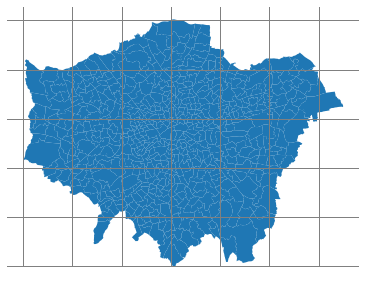

In [65]:
ax = gdf_london.plot(figsize=(8, 5))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

#### Step 2.3 Grid DataFrame

Prepare the dataframe that will be used to download the tiles from Digimap. DataFrame with the polygon coordinates.

In [66]:
union = cell.sjoin(gdf_london, how="inner", predicate='intersects')
union.head(1)

,geometry,index_right,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID
2,"POLYGON ((494585.231 173816.738, 494585.231 182799.708, 503568.200 182799.708, 503568.200 173816.738, 494585.231 173816.738))",123,Heathrow Villages,E05000331,2352.117,0.0,E09000017,Hillingdon,116716


In [67]:
# Drop duplicates index. 
union = union[~union.index.duplicated(keep='first')]

# Keep only geometry column
union = union[['geometry']]
# Change the crs to lat lon
union = union.to_crs(epsg=4326)
print(f'Number of polygon is {len(union)}')
union.head()

Number of polygon is 33


,geometry
2,"POLYGON ((-0.64008 51.45544, -0.63767 51.53619, -0.50820 51.53461, -0.51084 51.45387, -0.64008 51.45544))"
9,"POLYGON ((-0.51084 51.45387, -0.50820 51.53461, -0.37875 51.53289, -0.38161 51.45216, -0.51084 51.45387))"
8,"POLYGON ((-0.51346 51.37313, -0.51084 51.45387, -0.38161 51.45216, -0.38446 51.37142, -0.51346 51.37313))"
15,"POLYGON ((-0.38446 51.37142, -0.38161 51.45216, -0.25239 51.45030, -0.25547 51.36957, -0.38446 51.37142))"
16,"POLYGON ((-0.38161 51.45216, -0.37875 51.53289, -0.24930 51.53103, -0.25239 51.45030, -0.38161 51.45216))"


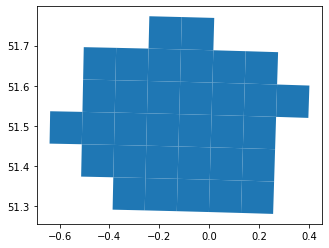

In [69]:
union.plot()

In [1]:
# Save the dataframe. 
union.reset_index().head(4)

NameError: ignored